# Yolov11, Faster-RNN, and SSD

In [2]:
import torch
import torchvision
from torchvision.io.image import decode_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import torchvision.transforms.functional as F
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights

from ultralytics import YOLO

import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = ("bus.jpg")


## Loading models

### Yolov11

In [3]:
yolov11 = YOLO("yolo11n.pt")


image 1/1 /home/kien/Desktop/projects/Amir_research/pretrain_models/bus.jpg: 640x480 4 persons, 1 bus, 112.3ms
Speed: 4.8ms preprocess, 112.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)


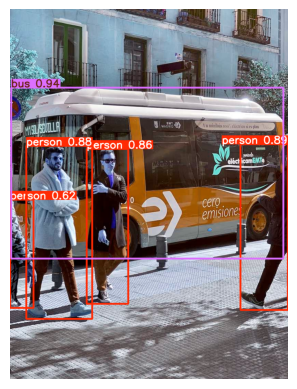

In [4]:
results = yolov11(img_path)
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()

### Utils for pytorch pretrain models

In [ ]:
def torch_models_pred(model, preprocess, inputs):
    #Utils for makking prediction using torch pretrain models
    batch = [preprocess(inputs)]
    pred = model(batch)
    return pred


def plot_torch_ouptut(img,prediction, categories):
    #util function to draw prediction boxes onto img. Img is in uint8 format.
    # Return boxes drawn on img with PIL format
    labels = [categories[i] for i in prediction["labels"]]
    boxes = draw_bounding_boxes(img, boxes=prediction["boxes"],
                            labels=labels,
                            colors="green",
                            label_colors="red",
                            width=4,
                            font="./../font/Sansation-Bold.ttf",
                            font_size=20)
    boxes_PIL = boxes.movedim(0, -1)

    return boxes_PIL

In [17]:
img_path = "bus.jpg"
img = decode_image(img_path)

### Faster-RNN

In [22]:
# Initialize model with pretrained weights
faster_rnn_weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
faster_rnn_model = fasterrcnn_resnet50_fpn_v2(weights=faster_rnn_weights, box_score_thresh=0.9).to(device)
faster_rnn_categories = faster_rnn_weights.meta["categories"]
faster_rnn_preprocess = faster_rnn_weights.transforms()

faster_rnn_model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

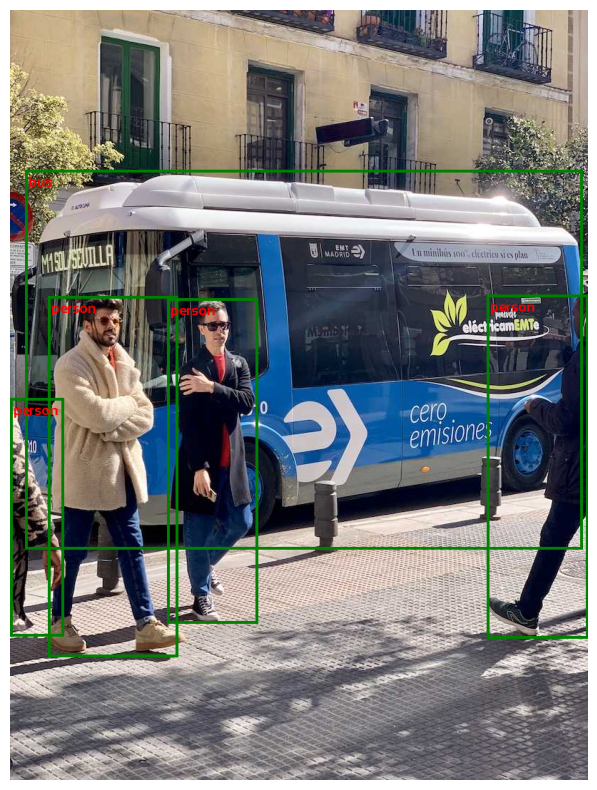

In [ ]:
fasterRNN_prediction = torch_models_pred(faster_rnn_model, faster_rnn_preprocess, img)[0]
labeled_img = plot_torch_ouptut(img,fasterRNN_prediction, faster_rnn_categories)

plt.figure(figsize=(10,10))
plt.imshow(labeled_img)
plt.axis("off")
plt.show()

### SSD

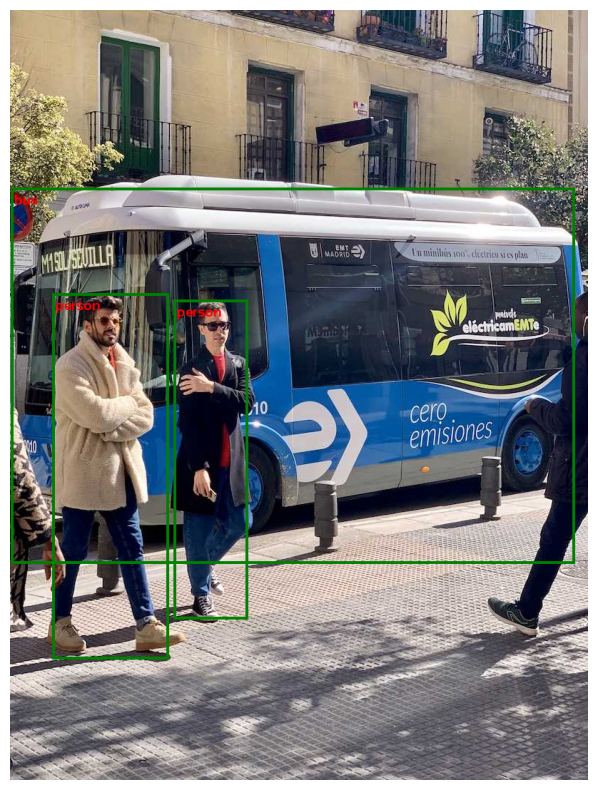

In [31]:
SSD_weights = SSD300_VGG16_Weights.COCO_V1
SSD_model = ssd300_vgg16(weights=SSD_weights).to(device)
SSD_categories = SSD_weights.meta["categories"]
SSD_preprocess = SSD_weights.transforms() 

SSD_model.eval()

SSD_pred = torch_models_pred(SSD_model, SSD_preprocess, img)[0]

#filter with conf threshold
conf_thresh = 0.7
keep = SSD_pred["scores"] >= conf_thresh

SSD_pred["boxes"] = SSD_pred["boxes"][keep]  
SSD_pred["labels"] = SSD_pred["labels"][keep]
SSD_pred["scores"] = SSD_pred["scores"][keep]

#draw
SSD_label_img = plot_torch_ouptut(img, SSD_pred, SSD_categories)
plt.figure(figsize=(10,10))
plt.imshow(SSD_label_img)
plt.axis("off")
plt.show()